In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from data_analysis_codes.tools import Plot2d
from data_analysis_codes.tools import Cstyle
from data_analysis_codes.tools import LinData
from data_analysis_codes.tools import FD as FD_file
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import GetVars_Plot2d as GVar
from data_analysis_codes.tools import Ricci_CoGrad_Weyl as RCW_file
plt.style.use(Cstyle.style1)

In [2]:
def shift_around_OD(data):
    icut = int(np.shape(data)[0]*3/4)
    databig = np.append(data[icut:,:,:], data[:icut,:,:], axis=0)
    databig = np.append(databig[:,icut:,:], databig[:,:icut,:], axis=1)
    databig = np.append(databig[:,:,icut:], databig[:,:,:icut], axis=2)
    return databig
def shift_to_OD(data):
    icut = int(np.shape(data)[0]*1/4)
    databig = np.append(data[icut:,:,:], data[:icut,:,:], axis=0)
    databig = np.append(databig[:,icut:,:], databig[:,:icut,:], axis=1)
    databig = np.append(databig[:,:,icut:], databig[:,:,:icut], axis=2)
    return databig

In [3]:
def interpolate(f):
    f_save = [f[0]]
    for i in range(len(f)-1):
        f_save += [np.average([f[i], f[i+1]]), f[i+1]]
    return np.array(f_save)

def extrapolate(f):
    return np.append(f, f[-1]+f[-1]-f[-2])

def get_error(f32, f64, f128):
    f32 = interpolate(interpolate(f32))
    f64 = interpolate(f64)
    while len(f32)<len(f128):
        f32 = extrapolate(f32)
    while len(f64)<len(f128):
        f64 = extrapolate(f64)
    c = abs(f32-f64)/abs(f64-f128)
    err = abs((f64-f128)/(c-1))
    for ic in range(len(c)):
        if err[ic]>abs(f32[ic]-f64[ic]) or err[ic]>abs(f64[ic]-f128[ic]):
            err[ic] = np.max([abs(f32[ic]-f64[ic]), abs(f64[ic]-f128[ic])])
    return err

In [4]:
def get_Theta(param, it):
    Lin = LinData.LinData_Class(param)
    FD = FD_file.FD_Class(param['dx'], param['dy'], param['dz'])
    RCW = RCW_file.Ricci_CoGrad_Weyl_Class(FD)
    get_var = GVar.Get_var(param, Lin)

    f = h5py.File('{}_it_{:06d}.hdf5'.format(param['h5datapath']+param['simname'], it), 'r')
    Kdict = get_var.get_the_curv(f, it)
    gdown = Kdict['metric_dic']['gdown']
    Gudd = RCW.Christoffel_symbol(gdown, Kdict['metric_dic']['gup'])
    Kdown = Kdict['Kdown']
    K = Kdict['K']

    # Shift metric
    gxx = shift_around_OD(gdown[0,0])
    gxy = shift_around_OD(gdown[0,1])
    gxz = shift_around_OD(gdown[0,2])
    gyy = shift_around_OD(gdown[1,1])
    gyz = shift_around_OD(gdown[1,2])
    gzz = shift_around_OD(gdown[2,2])

    # Spherical coord
    phi = np.sign(Lin.d3y) * np.arccos(Lin.d3x / np.sqrt(Lin.d3x*Lin.d3x + Lin.d3y*Lin.d3y))
    phi[np.logical_and(np.sign(Lin.d3y) == 0.0, np.sign(Lin.d3x)<0)] = np.pi
    phi[np.where(Lin.d3x*Lin.d3x + Lin.d3y*Lin.d3y == 0)] = 0
    r = np.sqrt(Lin.d3x*Lin.d3x + Lin.d3y*Lin.d3y + Lin.d3z*Lin.d3z)
    theta = np.arccos(Lin.d3z / r)
    theta[np.where(r == 0)] = 0

    # normalisation term
    xynorm = (np.cos(phi)**2 * gxx + 2 * np.cos(phi) * np.sin(phi) * gxy + np.sin(phi)**2 * gyy)
    xyznorm = (np.sin(theta)**2 * xynorm + 2 * np.cos(theta) * np.sin(theta) * (np.cos(phi) * gxz + np.sin(phi) * gyz)+ np.cos(theta)**2 * gzz)

    # outward pointing unit vector
    Sx = np.cos(phi) * np.sin(theta) / np.sqrt(xyznorm)
    Sy = np.sin(phi) * np.sin(theta) / np.sqrt(xyznorm)
    Sz = np.cos(theta) / np.sqrt(xyznorm)
    sup = np.array([shift_to_OD(Sx), shift_to_OD(Sy), shift_to_OD(Sz)])

    # Theta
    Disi = np.einsum('aa... -> ...', RCW.CovD3_tensor1up(Gudd, sup))
    Kss = np.einsum('ij..., i..., j... -> ...', Kdown, sup, sup)
    Theta_out = ( Disi - K + Kss )/np.sqrt(2)
    Theta_in = ( - Disi - K + Kss )/np.sqrt(2)
    return Theta_out, Theta_in, Kdict['metric_dic']['gdet']

In [5]:
param128 = RRead.read_parameters('pflrw_d3e2_L1821_t1_N128_LCDM')
Lin128 = LinData.LinData_Class(param128)

param64 = RRead.read_parameters('pflrw_d3e2_L1821_t1_N64_LCDM')
Lin64 = LinData.LinData_Class(param64)

param32 = RRead.read_parameters('pflrw_d3e2_L1821_t1_N32_LCDM')
Lin32 = LinData.LinData_Class(param32)

 read time file
 read time file
 read time file


In [6]:
def vertex(phi):
    idxOD = int(len(phi)/4)
    idxUD = int(3*len(phi)/4)-2
    return phi[idxOD:idxUD, idxOD, idxOD]
def edge(phi):
    idxOD = int(len(phi)/4)
    idxUD = int(3*len(phi)/4)-2
    return np.array([phi[j, j, idxOD] for j in range(idxOD, idxUD)])
def face(phi):
    idxOD = int(len(phi)/4)
    idxUD = int(3*len(phi)/4)-2
    return np.array([phi[j, j, j] for j in range(idxOD, idxUD)])

In [7]:
def plot_Theta(it32, withRH=False):
    it64 = it32*2
    it128 = it64*2
    Theta128_out, Theta128_in, gdet = get_Theta(param128, it128)
    Theta64_out, Theta64_in, gdet = get_Theta(param64, it64)
    Theta32_out, Theta32_in, gdet = get_Theta(param32, it32)
    
    idxOD = int(param128['Nx']/4)
    idxUD = int(3*param128['Nx']/4)-2
    r = np.sqrt((Lin128.d3x[idxOD:idxUD, idxOD, idxOD] - Lin128.d3x[idxOD, idxOD, idxOD])**2
               +(Lin128.d3y[idxOD:idxUD, idxOD, idxOD] - Lin128.d3x[idxOD, idxOD, idxOD])**2
               +(Lin128.d3z[idxOD:idxUD, idxOD, idxOD] - Lin128.d3x[idxOD, idxOD, idxOD])**2)/param128['Lx']
    H = Lin128.temp_from_temp('H', 'it', it128)
    alphafac = 0.3
    L = param128['Lx']

    plt.figure(figsize=(23, 5))

    plt.subplot(141)
    coorcoor = Lin128.d3xyz/param128['Lx']
    data = np.log10(abs(Theta128_out[:,:,int(param128['Nx']/4)]).T * L)
    plt.pcolormesh(coorcoor, coorcoor, data, shading='nearest')
    plt.gca().set_aspect("equal")
    plt.colorbar(extend='both')
    plt.xlabel(r'$x\;\;[\lambda_{pert}]$')
    plt.ylabel(r'$y\;\;[\lambda_{pert}]$')
    plt.title(r'$log_{10}(|\Theta_{out}|)$,'+"\n"+'$a/a_{IN}=$'
                +'{:.1f}'.format(Lin128.temp_from_temp('an', 'it', it128)))

    plt.subplot(142)
    plt.semilogy(r, abs(vertex(Theta128_out)) * L, label='vertex')
    err = get_error(vertex(Theta32_out), vertex(Theta64_out), vertex(Theta128_out))
    plt.fill_between(r, abs(vertex(Theta128_out)-err) * L, abs(vertex(Theta128_out)+err) * L, alpha=alphafac)
    plt.semilogy(r*np.sqrt(2), abs(edge(Theta128_out)) * L, linestyle='-.', label='edge')
    err = get_error(edge(Theta32_out), edge(Theta64_out), edge(Theta128_out))
    plt.fill_between(r*np.sqrt(2), abs(edge(Theta128_out)-err) * L, abs(edge(Theta128_out)+err) * L, alpha=alphafac)
    plt.semilogy(r*np.sqrt(3), abs(face(Theta128_out)) * L, linestyle='--', label='face')
    err = get_error(face(Theta32_out), face(Theta64_out), face(Theta128_out))
    plt.fill_between(r*np.sqrt(3), abs(face(Theta128_out)-err) * L, abs(face(Theta128_out)+err) * L, alpha=alphafac)
    plt.grid()
    plt.xlabel(r'$R_{com} \;\; [\lambda_{pert}]$')
    plt.title(r'$|\Theta_{out}| \;\; [\lambda_{pert}^{-1}]$')
    plt.legend()

    plt.subplot(143)
    plt.semilogy(r, abs(vertex(Theta128_in)) * L, label='vertex')
    err = get_error(vertex(Theta32_in), vertex(Theta64_in), vertex(Theta128_in))
    plt.fill_between(r, abs(vertex(Theta128_in)-err) * L, abs(vertex(Theta128_in)+err) * L, alpha=alphafac)
    plt.semilogy(r*np.sqrt(2), abs(edge(Theta128_in)) * L, linestyle='-.', label='edge')
    err = get_error(edge(Theta32_in), edge(Theta64_in), edge(Theta128_in))
    plt.fill_between(r*np.sqrt(2), abs(edge(Theta128_in)-err) * L, abs(edge(Theta128_in)+err) * L, alpha=alphafac)
    plt.semilogy(r*np.sqrt(3), abs(face(Theta128_in)) * L, linestyle='--', label='face')
    err = get_error(face(Theta32_in), face(Theta64_in), face(Theta128_in))
    plt.fill_between(r*np.sqrt(3), abs(face(Theta128_in)-err) * L, abs(face(Theta128_in)+err) * L, alpha=alphafac)
    if withRH:
        RHcom = 1/(Lin128.temp_from_temp('H', 'it', it128) * Lin128.temp_from_temp('a', 'it', it128))
        plt.axvline(x=RHcom / L, color='k')
    plt.grid()
    plt.xlabel(r'$R_{com} \;\; [\lambda_{pert}]$')
    plt.title(r'$|\Theta_{in}| \;\; [\lambda_{pert}^{-1}]$')

    plt.subplot(144)
    coorcoor = Lin128.d3xyz/param128['Lx']
    data = np.log10(abs(Theta128_in[:,:,int(param128['Nx']/4)]).T * L)
    plt.pcolormesh(coorcoor, coorcoor, data, shading='nearest')
    plt.gca().set_aspect("equal")
    plt.colorbar(extend='both')
    plt.xlabel(r'$x\;\;[\lambda_{pert}]$')
    plt.title(r'$log_{10}(|\Theta_{in}|)$')

 read time file


/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


 read time file
 read time file


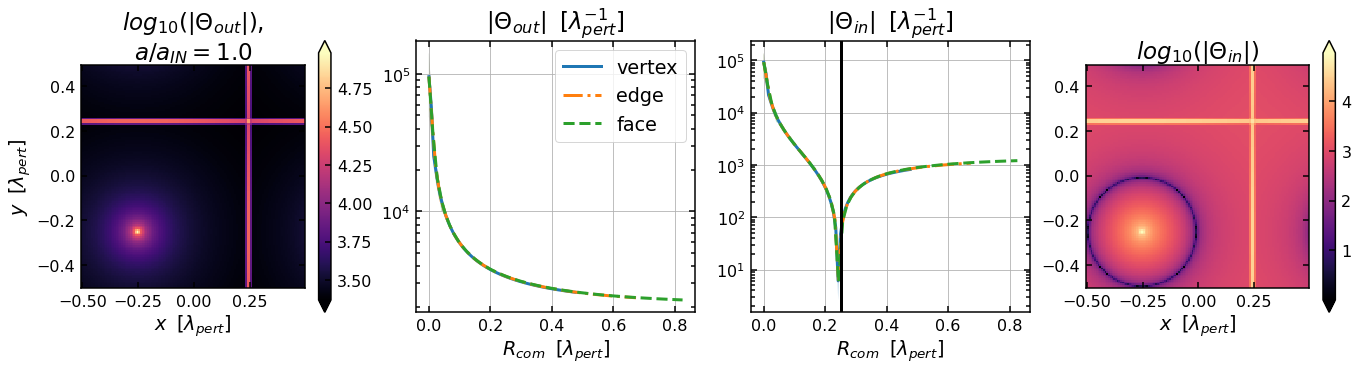

In [8]:
plot_Theta(0, withRH=True)

 read time file


/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


 read time file
 read time file


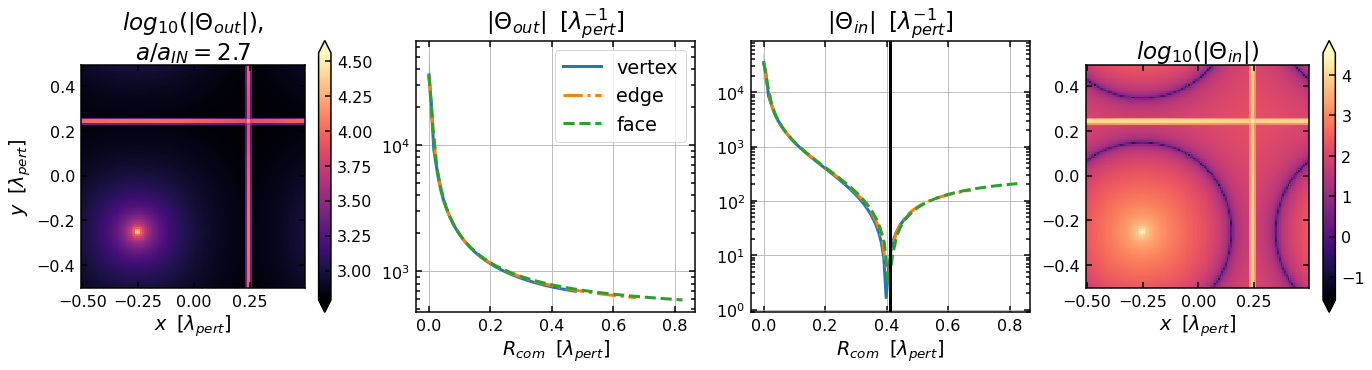

In [10]:
plot_Theta(100, withRH=True)

 read time file


/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


 read time file
 read time file


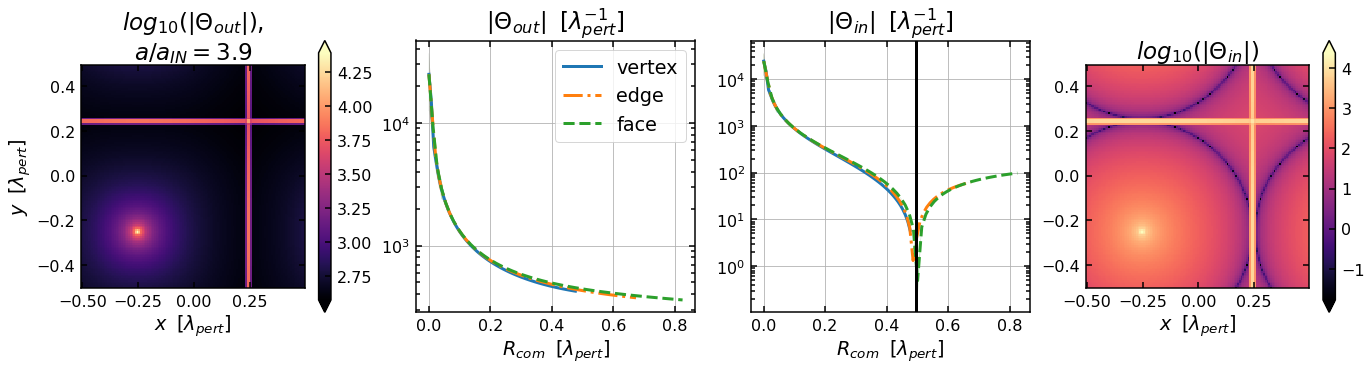

In [11]:
plot_Theta(200, withRH=True)

 read time file


/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


 read time file
 read time file


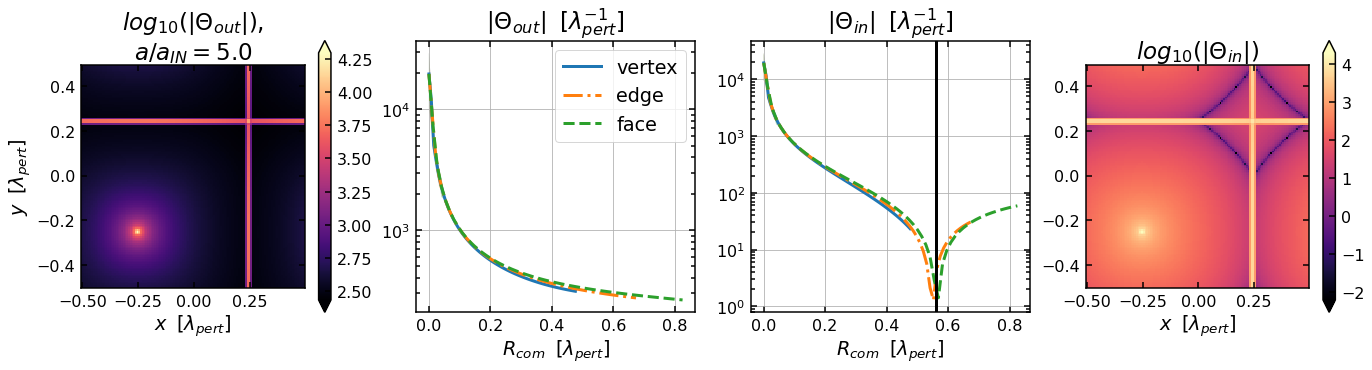

In [12]:
plot_Theta(300, withRH=True)

 read time file


/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


 read time file
 read time file


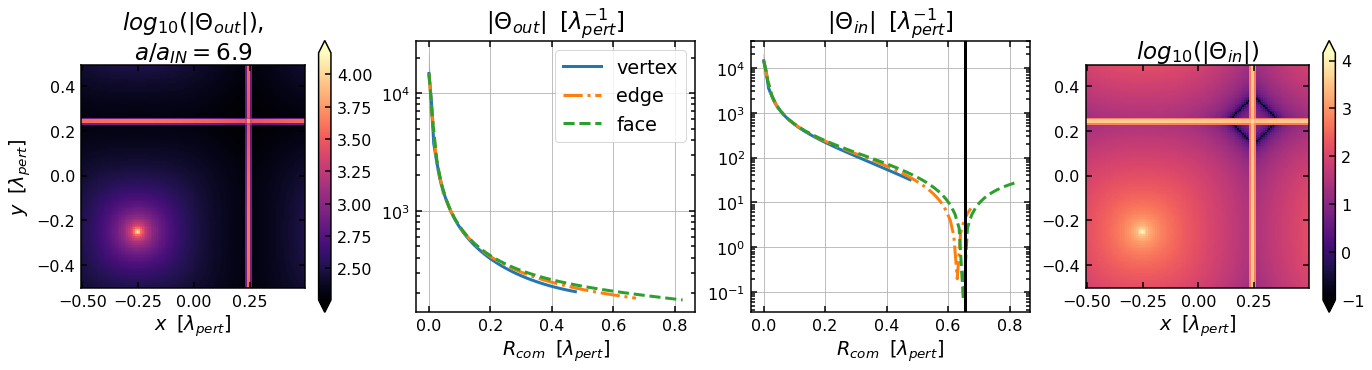

In [9]:
plot_Theta(500, withRH=True)

 read time file


/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


 read time file
 read time file


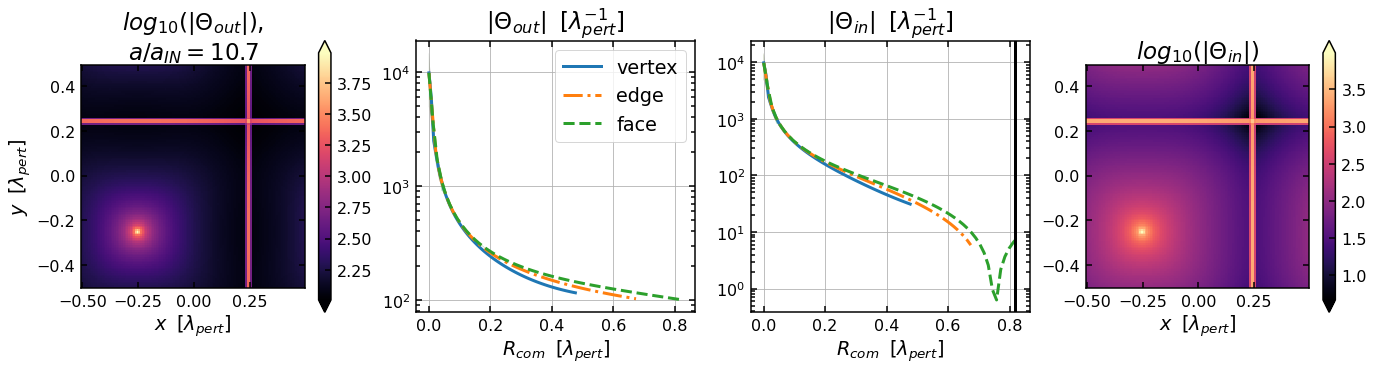

In [13]:
plot_Theta(1000, withRH=True)

 read time file


/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


 read time file
 read time file


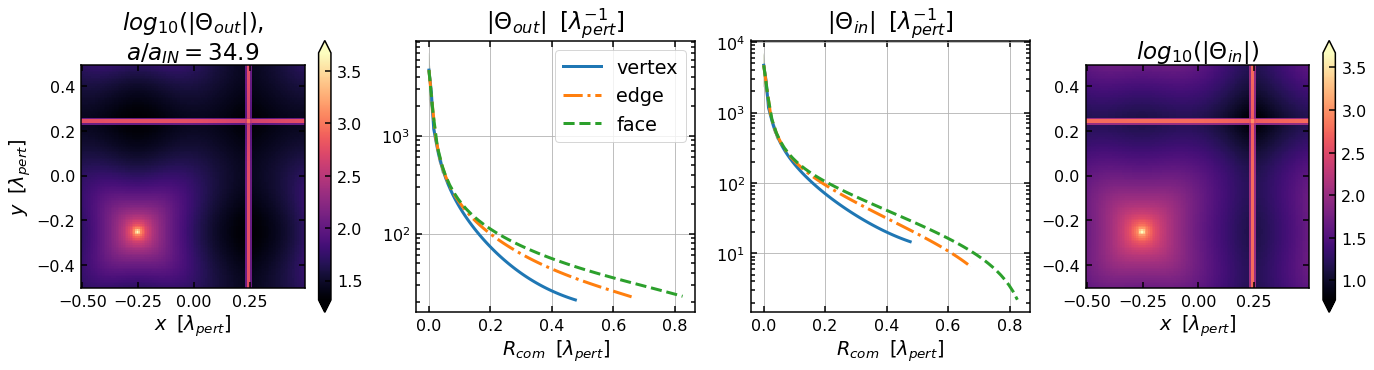

In [14]:
plot_Theta(6000)

 read time file


/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


 read time file
 read time file


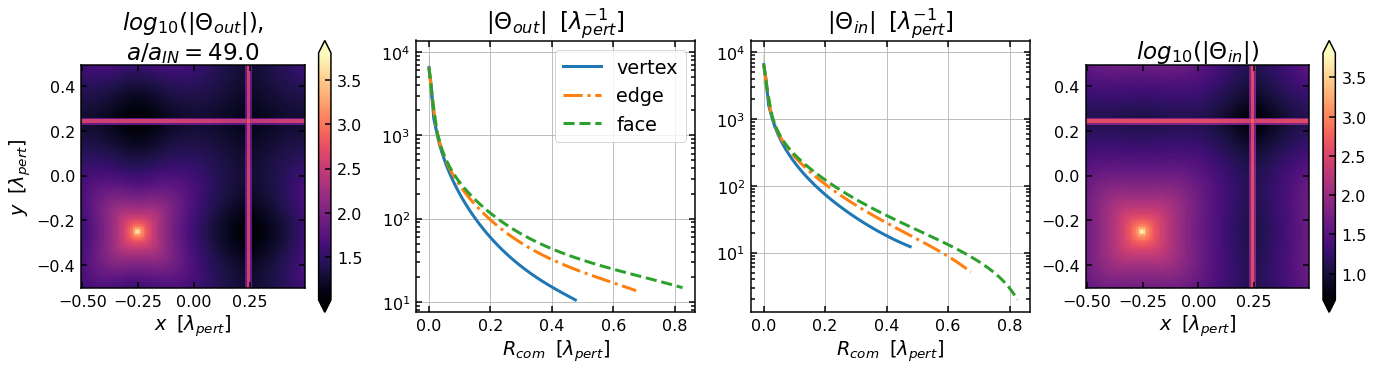

In [16]:
plot_Theta(10000)

 read time file


/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


 read time file
 read time file


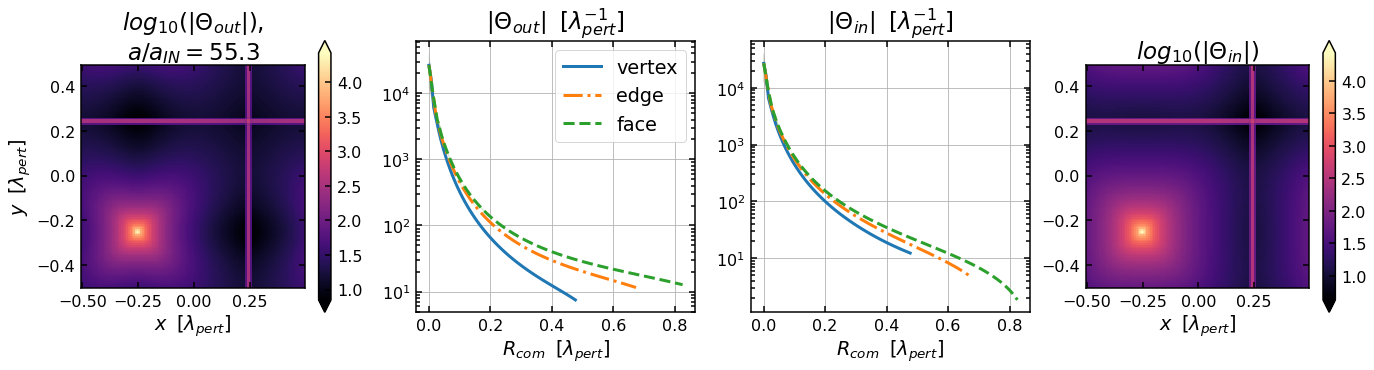

In [17]:
plot_Theta(12000)